# Simulations for multi-resolution deblending

In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
import galsim_compare_tools as gct

# Import Packages and setup
import numpy as np
import scarlet.display
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
from functools import partial

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

In [2]:
%pylab inline
# Setup: declaring survey properties, loading catalog and making sure we have pretty colorbars
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, WFIRST, HSC, RUBIN = gct.load_surveys()

center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

mymap = 'gnuplot2'#mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


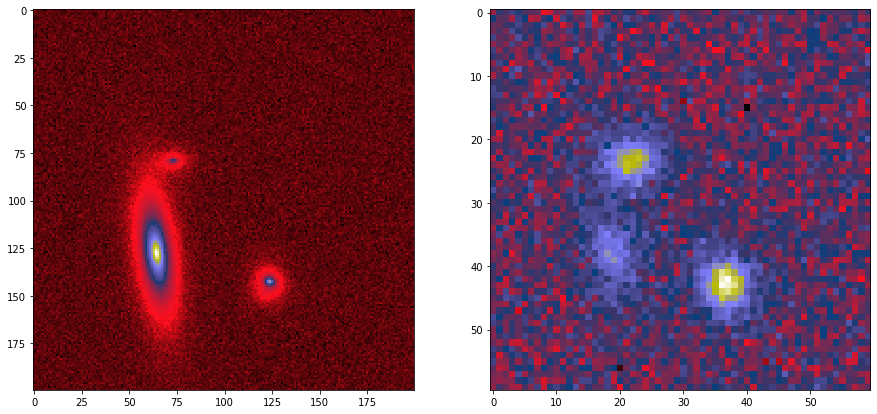

In [3]:
hr_dict = HST
lr_dict = RUBIN

nlr = 60
nhr = np.int(np.around(nlr*lr_dict['pixel']/hr_dict['pixel'], decimals = 3))
mk_sim = 1
if mk_sim:
    hr, lr, wcs_hr, wcs_lr, psf_hr, psf_lr, shifts = gct.mk_scene(hr_dict, lr_dict, cat, 
                                                                  (nhr,nhr), (nlr,nlr), 4, gal_type = 'parametric')
    hr = hr[None, :,:]
else: 
    datas = np.load('Multires_simulation.npz', allow_pickle = True)
    hr, lr = datas['images']
    psf_hr, psf_lr = datas['psf']
    wcs_hr, wcs_lr = datas['wcs']
    wcs_hr.array_shape = wcs_hr.wcs.crpix*2
    wcs_lr.array_shape = wcs_lr.wcs.crpix*2
    shifts = np.zeros((2,4))
    
plt.figure(figsize = (15, 30))
plt.subplot(121)
plt.imshow(hr[0])
plt.subplot(122)
plt.imshow(lr[0])
plt.show()

In [4]:
# Channels
channels_hr = ['F814w']
channels_lr = ['g','r','i']

hr = hr
lr = lr

# Scale the HST data
_,n1,n2 = np.shape(hr)
# Scale the HSC data
r, N1, N2 = lr.shape

In [5]:
import sep

class Data():
    
    def __init__(self, images, wcss, psfs, channels):
        self.images = images
        self.wcs = wcss
        self.psfs = psfs
        self.channels = channels

def interpolate(data_lr, data_hr):
    #Interpolate low resolution data to high resolution
    coord_lr0 = (np.arange(data_lr.images.shape[1]), np.arange(data_lr.images.shape[1]))
    coord_hr = (np.arange(data_hr.images.shape[1]), np.arange(data_hr.images.shape[1]))
    coord_lr = scarlet.resampling.convert_coordinates(coord_lr0, data_lr.wcs, data_hr.wcs)
    
    interp = []
    for image in data_lr.images:
        interp.append(scarlet.interpolation.sinc_interp(image[None, :,:], coord_hr, coord_lr, angle=None)[0].T)
    return np.array(interp)
        
def makeCatalog_multi(data_lr, data_hr, lvl = 3, wave = True):
    #Create observations for each image
    #Interpolate low resolution to high resolution
    interp = interpolate(data_lr, data_hr)
    #Normalisation of the interpolate low res images
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    #Normalisation of the high res data
    hr_images = data_hr.images/np.sum(data_hr.images, axis = (1,2))[:,None, None]
    #Detection image as the sum over all images
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            #Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl = 4).coefficients
            wave_detect[:,-1,:,:] = 0
            detect = Starlet(coefficients = wave_detect).image
        else:
            #Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            detect = detect_image
    

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    bg_rms = []
    for data in datas:
        bg_rms.append(mad_wavelet(data.images))
 
    return catalog, bg_rms, detect_image

def makeCatalog(data, lvl = 3, wave = True):
    #Normalisation of the data
    hr_images = data/np.sum(data, axis = (1,2))[:,None, None]
    #Detection image as the sum over all images
    detect_image = np.sum(hr_images, axis = 0)
    
    if np.size(detect_image.shape) == 3:
        if wave:
            #Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl = 4).coefficients
            wave_detect[:,-1,:,:] = 0
            detect = Starlet(coefficients = wave_detect).image
        else:
            #Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            detect = detect_image
    

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    bg_rms = mad_wavelet(data)

    return catalog, bg_rms, detect_image

In [6]:
data_hr =  Data(hr, wcs_hr, psf_hr, channels_hr)
data_lr =  Data(lr, wcs_lr, psf_lr, channels_lr)

datas = [data_lr, data_hr]
wave = 1
lvl = 3
catalog_multi, bg_rms_multi, detect_multi = makeCatalog_multi(data_lr, data_hr, lvl, wave)

catalog_lr, bg_rms_lr, detect_hsc = makeCatalog(lr, lvl, wave)
catalog_hr, bg_rms_hr, detect_hst = makeCatalog(hr, lvl, wave)

weights_hr = np.ones_like(hr) / (bg_rms_multi[1]**2)[:, None, None]
weights_lr = np.ones_like(lr) / (bg_rms_multi[0]**2)[:, None, None]

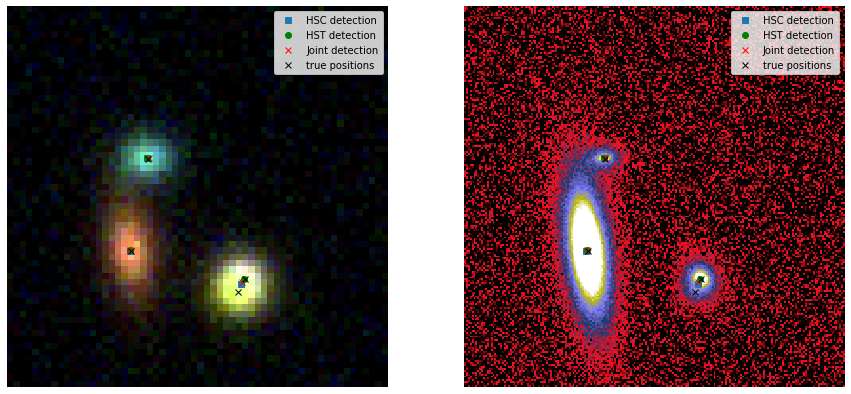

In [7]:
# Create a color mapping for the HSC image
lr_norm = AsinhMapping(minimum=0, stretch=1, Q=0.1)
hr_norm = AsinhMapping(minimum=0, stretch=1, Q=1)

# Get the source coordinates from the HST catalog
xtrue, ytrue = shifts[:,0], shifts[:,1]
xt,yt = catalog_hr['x'], catalog_hr['y']
xm,ym = catalog_multi['x'], catalog_multi['y']
xc,yc = catalog_lr['x'], catalog_lr['y']
# Convert the HST coordinates to the HSC WCS
ratrue, dectrue = wcs_hr.wcs_pix2world(ytrue,xtrue,0.5)
rat, dect = wcs_hr.wcs_pix2world(yt,xt,0)
ram, decm = wcs_hr.wcs_pix2world(ym,xm,0)
rac, decc = wcs_lr.wcs_pix2world(yc,xc, 0)

Ytrue, Xtrue = wcs_lr.wcs_world2pix(ratrue, dectrue,0)
Yt,Xt = wcs_lr.wcs_world2pix(rat, dect, 0)
Ym,Xm = wcs_lr.wcs_world2pix(ram, decm, 0)
Yc,Xc = wcs_hr.wcs_world2pix(rac, decc, 0)
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(lr, norm=lr_norm)
# Apply Asinh to the HST data
hr_img = scarlet.display.img_to_rgb(hr, norm=hr_norm)

plt.figure(figsize=(15,30))
plt.subplot(121)
plt.imshow(img_rgb)
plt.axis('off')
plt.plot(xc,yc, 's', label = 'HSC detection')
plt.plot(Xt,Yt, 'og', label = 'HST detection')
plt.plot(Xm,Ym, 'xr', label = 'Joint detection')
plt.plot(Xtrue,Ytrue, 'xk', label = 'true positions')
plt.legend()

plt.subplot(122)
plt.imshow(hr_img[:,:,0])
plt.axis('off')
plt.plot(Xc,Yc, 's', label = 'HSC detection')
plt.plot(xt,yt, 'og', label = 'HST detection')
plt.plot(xm,ym, 'xr', label = 'Joint detection')
plt.plot(xtrue,ytrue, 'xk', label = 'true positions')
plt.legend()
plt.show()

In [8]:
#Automated frame definition
# define two observation packages and match to frame
multi_hr = scarlet.Observation(hr, wcs=wcs_hr, psfs=psf_hr, channels=channels_hr, weights=weights_hr)
multi_lr = scarlet.Observation(lr, wcs=wcs_lr, psfs=psf_lr, channels=channels_lr, weights=weights_lr)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [multi_lr, multi_hr]
frame = scarlet.Frame.from_observations(obs, coverage = 'intersection')
multi_lr, multi_hr = obs

In [9]:
obs_hr = scarlet.Observation(hr, wcs=wcs_hr, psfs=psf_hr, channels=channels_hr, weights=weights_hr)
obs_lr = scarlet.Observation(lr, wcs=wcs_lr, psfs=psf_lr, channels=channels_lr, weights=weights_lr)

lr_frame = scarlet.Frame(
    lr.shape,
    wcs = wcs_lr,
    psfs=psf_lr,
    channels=channels_lr)
obs_lr.match(lr_frame)

hr_frame = scarlet.Frame(
    hr.shape,
    wcs = wcs_hr,
    psfs=psf_hr,
    channels=channels_hr)
obs_hr.match(hr_frame)


In [10]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs, filtered_coadd = True)

# Source initialisation
sources = [
    scarlet.ExtendedSource(frame, (ram[i], decm[i]), obs, 
                           symmetric=False, 
                           monotonic=False, 
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff, min_grad = 0.)
    for i in range(ram.size)
]

blend_multi = scarlet.Blend(sources, obs)

In [11]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_lr)

# Source initialisation
lr_sources = [
    scarlet.ExtendedSource(lr_frame, (rac[i], decc[i]), obs_lr, 
                           symmetric=False, 
                           monotonic=True, min_grad = 0.)
    for i in range(rac.size)
]

blend_lr = scarlet.Blend(lr_sources, obs_lr)

In [12]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hr)

# Source initialisation
hr_sources = [
    scarlet.ExtendedSource(hr_frame, (rat[i], dect[i]), obs_hr, 
                           symmetric=False, 
                           monotonic=True, min_grad = 0.)
    for i in range(rat.size)
]

blend_hr = scarlet.Blend(hr_sources, obs_hr)

In [13]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_lr)

# Source initialisation
lr_sources = [
    scarlet.ExtendedSource(lr_frame, (ram[i], decm[i]), obs_lr, 
                           symmetric=False, 
                           monotonic=True,  min_grad = 0.)
    for i in range(ram.size)
]

blend_multilr = scarlet.Blend(lr_sources, obs_lr)

In [14]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hr)

# Source initialisation
hr_sources = [
    scarlet.ExtendedSource(hr_frame, (ram[i], decm[i]), obs_hr, 
                           symmetric=0, 
                           monotonic=True,  min_grad = 0.)
    for i in range(ram.size)
]

blend_multihr = scarlet.Blend(hr_sources, obs_hr)

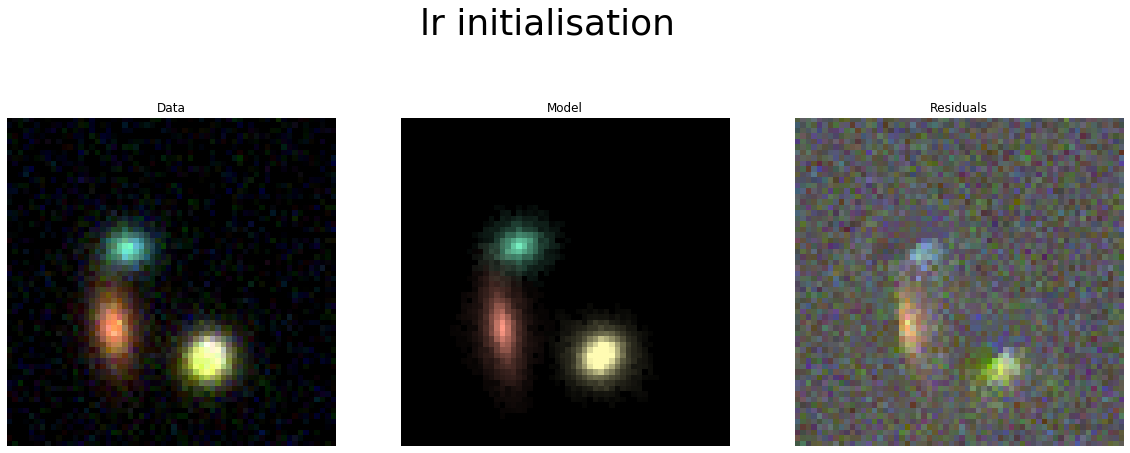

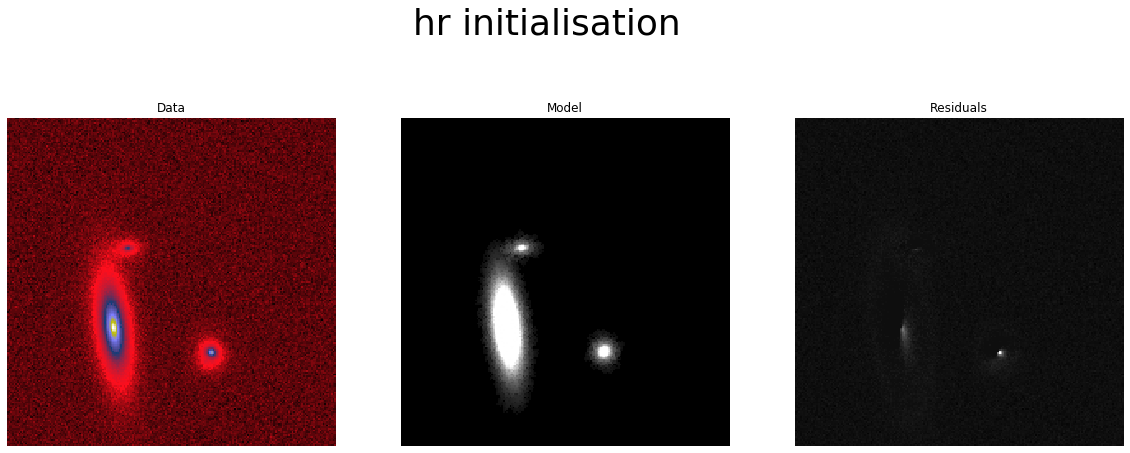

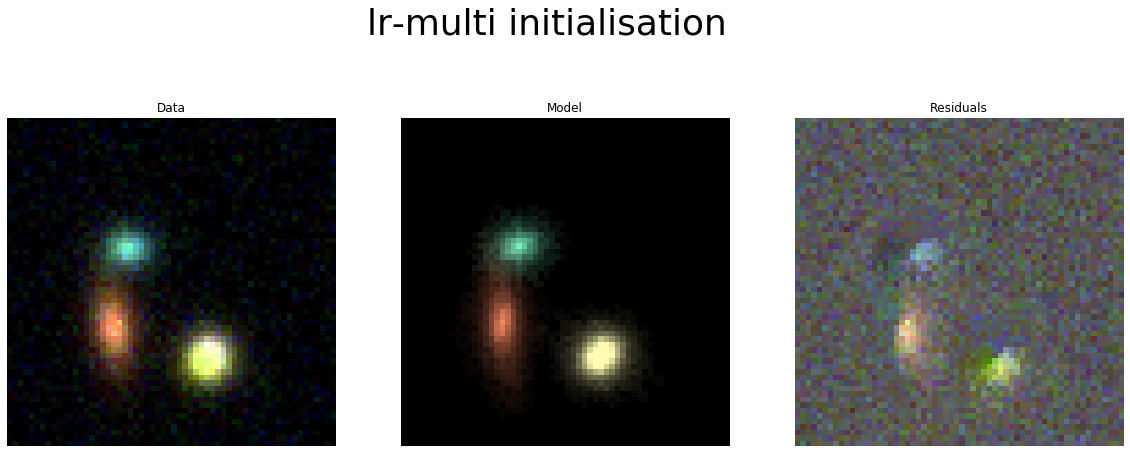

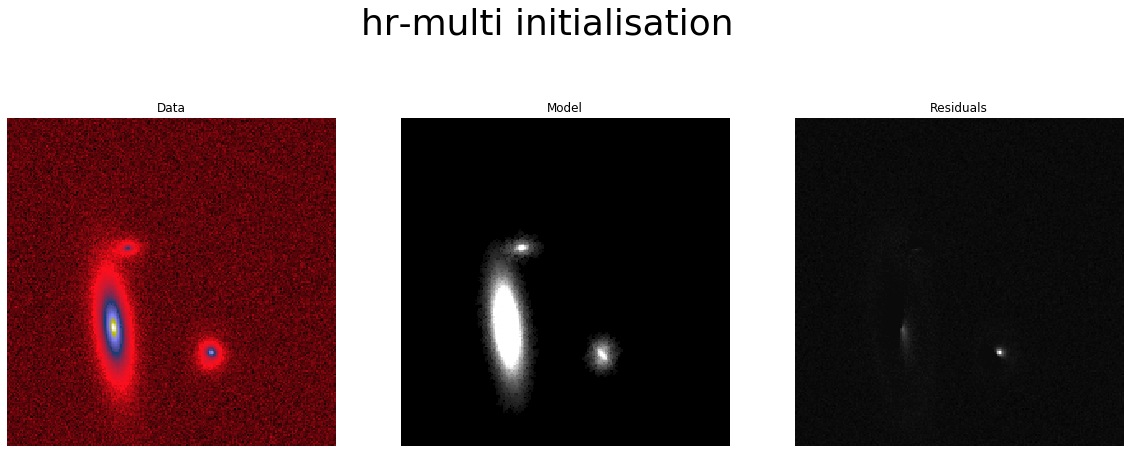

In [15]:
def display_init(blend, obs, data, ids, img, title):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=lr_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data")
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model")
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals")
    pass

display_init(blend_lr, obs_lr, lr, 0, img_rgb, 'lr initialisation')
display_init(blend_hr, obs_hr, hr, 1, hr[0], 'hr initialisation')
display_init(blend_multilr, obs_lr, lr, 2, img_rgb, 'lr-multi initialisation')
display_init(blend_multihr, obs_hr, hr, 3, hr[0], 'hr-multi initialisation')

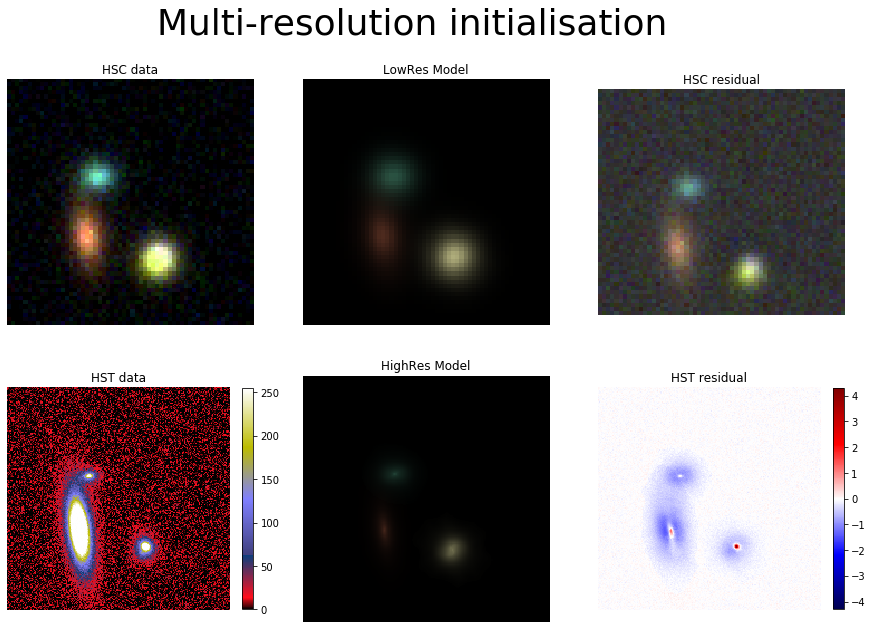

In [16]:
# Load the model and calculate the residual
model_multi = blend_multi.get_model()

model_lr = multi_lr.render(model_multi)
init_rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=lr_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=lr_norm)
residual_lr = lr - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (hr - multi_hr.render(model_multi))[0]
vmax = np.abs(residual_hr).max()

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.suptitle('Multi-resolution initialisation', fontsize=36)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.axis('off')
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.axis('off')
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hr_img[:,:,0])
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

scarlet ran for 300 iterations to logL = 62666.59679679255


Text(0, 0.5, 'log-Likelihood')

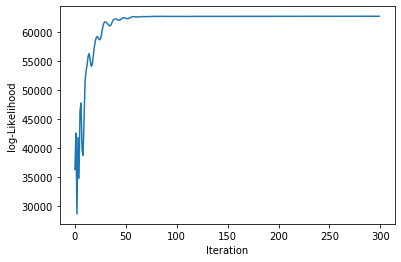

In [17]:
blend_hr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hr.loss), -blend_hr.loss[-1]))
plt.plot(-np.array(blend_hr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 95 iterations to logL = 18337.351276789486


Text(0, 0.5, 'log-Likelihood')

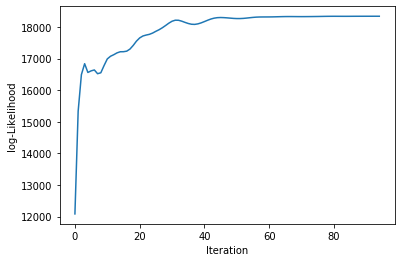

In [18]:
blend_lr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_lr.loss), -blend_lr.loss[-1]))
plt.plot(-np.array(blend_lr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 300 iterations to logL = 54379.093969230875


Text(0, 0.5, 'log-Likelihood')

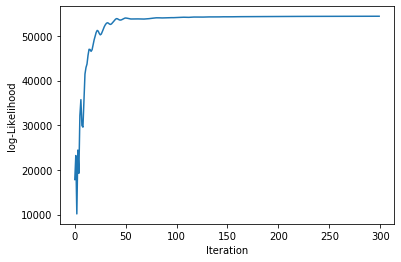

In [19]:
blend_multihr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multihr.loss), -blend_multihr.loss[-1]))
plt.plot(-np.array(blend_multihr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 75 iterations to logL = 18376.91182744864


Text(0, 0.5, 'log-Likelihood')

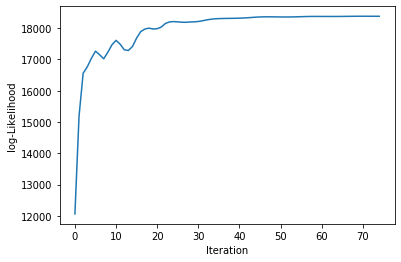

In [20]:
blend_multilr.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multilr.loss), -blend_multilr.loss[-1]))
plt.plot(-np.array(blend_multilr.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

AssertionError: 

scarlet ran for 1 iterations to logL = -217373.9990844543


Text(0, 0.5, 'log-Likelihood')

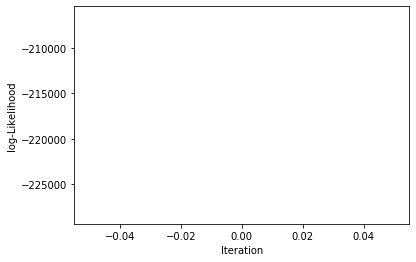

In [21]:
%time blend_multi.fit(200, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multi.loss), -blend_multi.loss[-1]))
plt.plot(-np.array(blend_multi.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

300


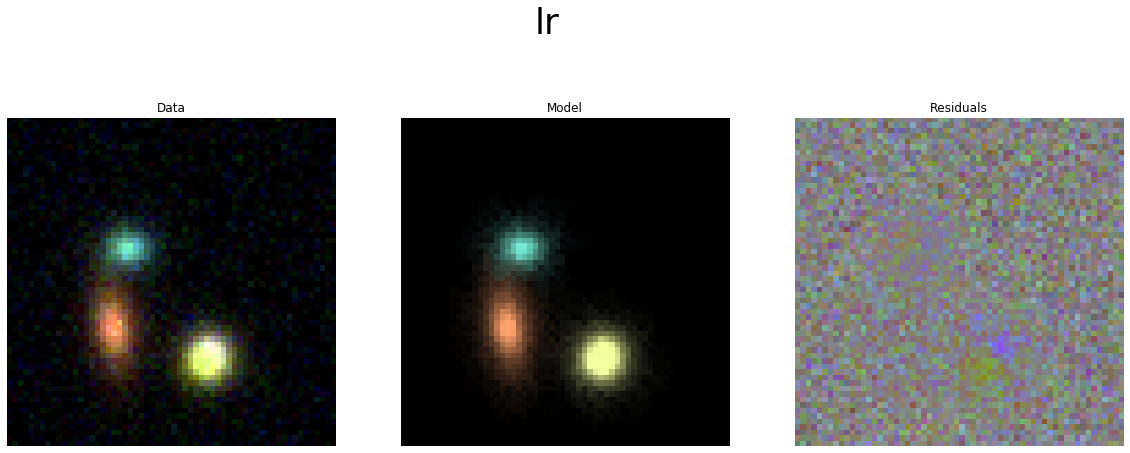

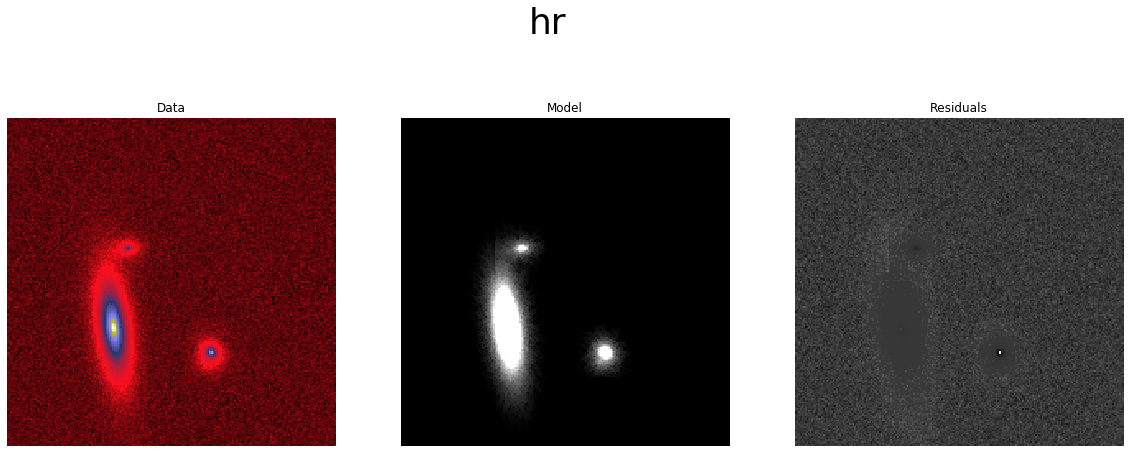

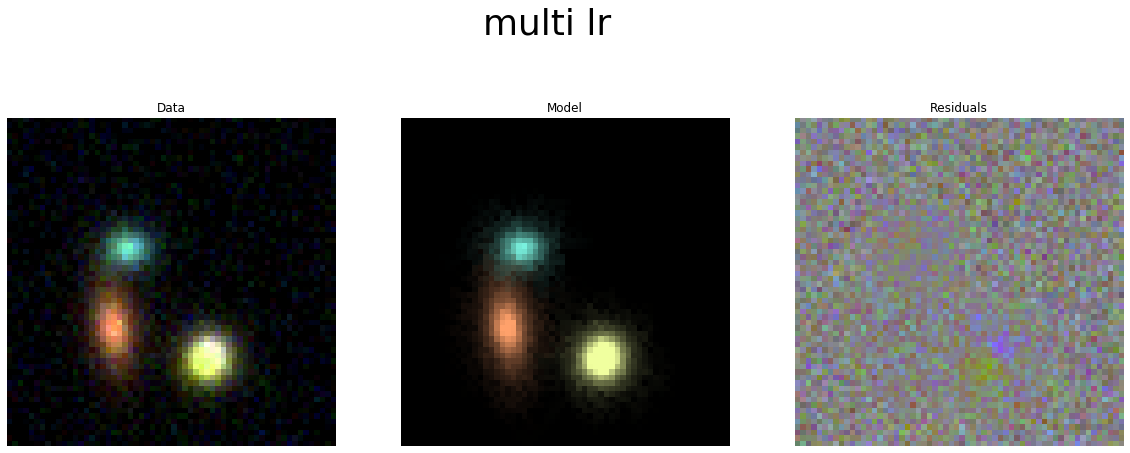

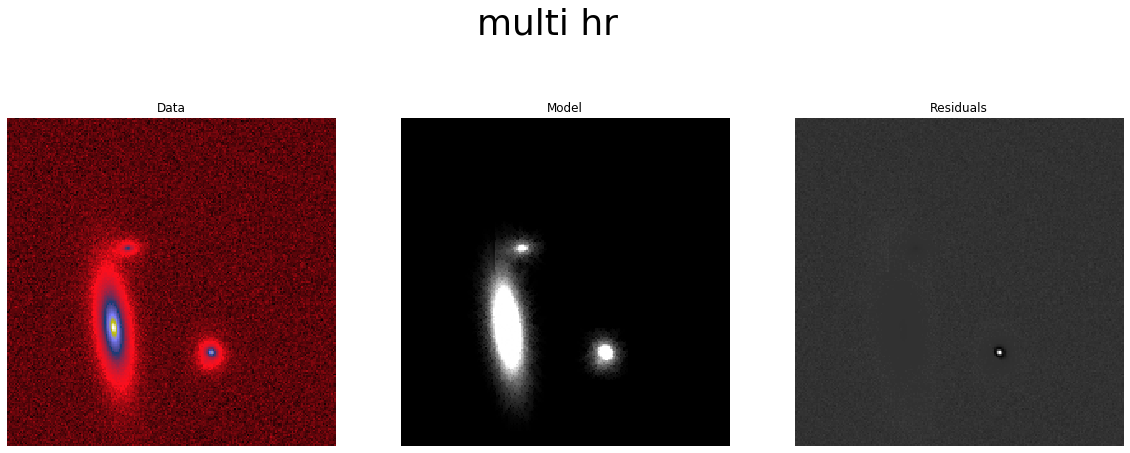

In [22]:
print(len(blend_hr.loss))
display_init(blend_lr, obs_lr, lr, 0, img_rgb, 'lr')
display_init(blend_hr, obs_hr, hr, 1, hr[0], 'hr')
display_init(blend_multilr, obs_lr, lr, 2, img_rgb, 'multi lr')
display_init(blend_multihr, obs_hr, hr, 3, hr[0], 'multi hr')

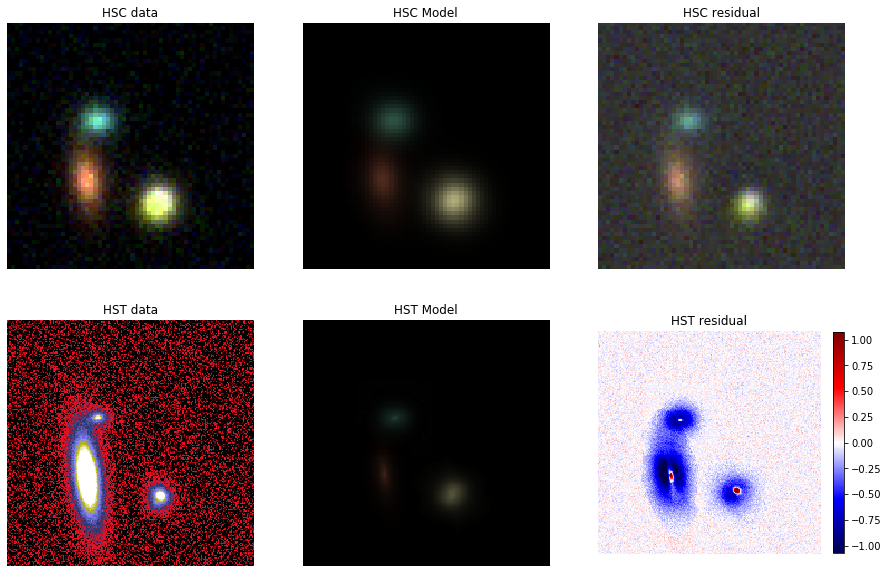

In [23]:
model_multi = blend_multi.get_model()
model_hr = multi_hr.render(model_multi)
model_lr = multi_lr.render(model_multi)


lrhr_norm = AsinhMapping(minimum=0, stretch=1, Q=5)
rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=lrhr_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=lr_norm)
residual_lr = lr - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:])

# Get the HR residual
residual_hr = (hr - model_hr)[0]
vmax = np.abs(residual_hr).max()/4

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.axis('off')
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.axis('off')
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin = -vmax, vmax = vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hr_img[:,:,0])
plt.axis('off')
plt.title('HST data')
plt.show()

source number  0


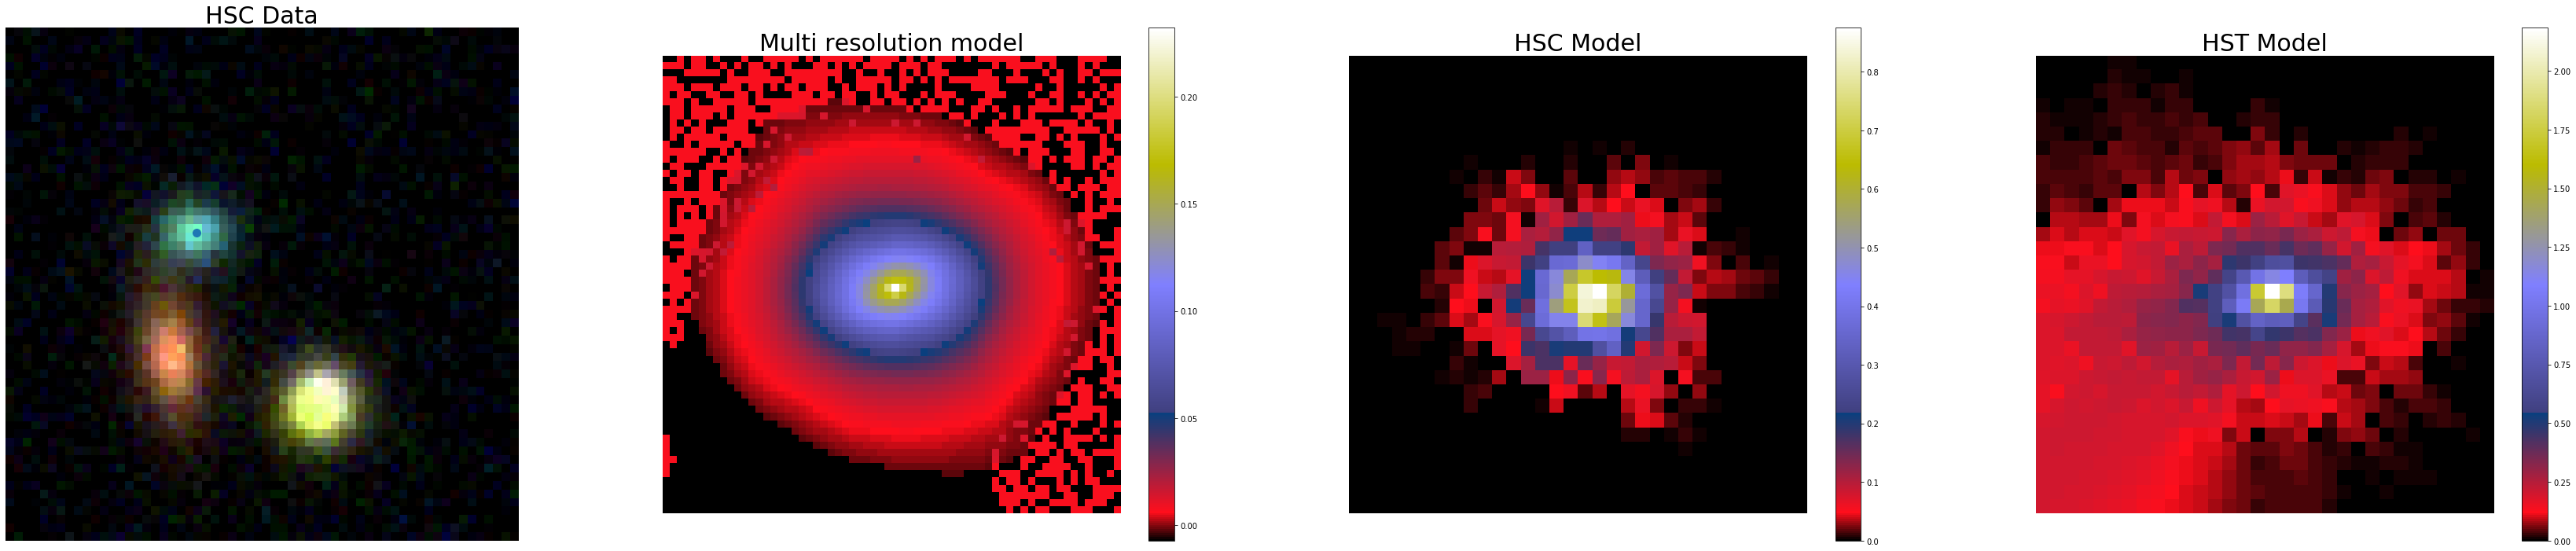

source number  1


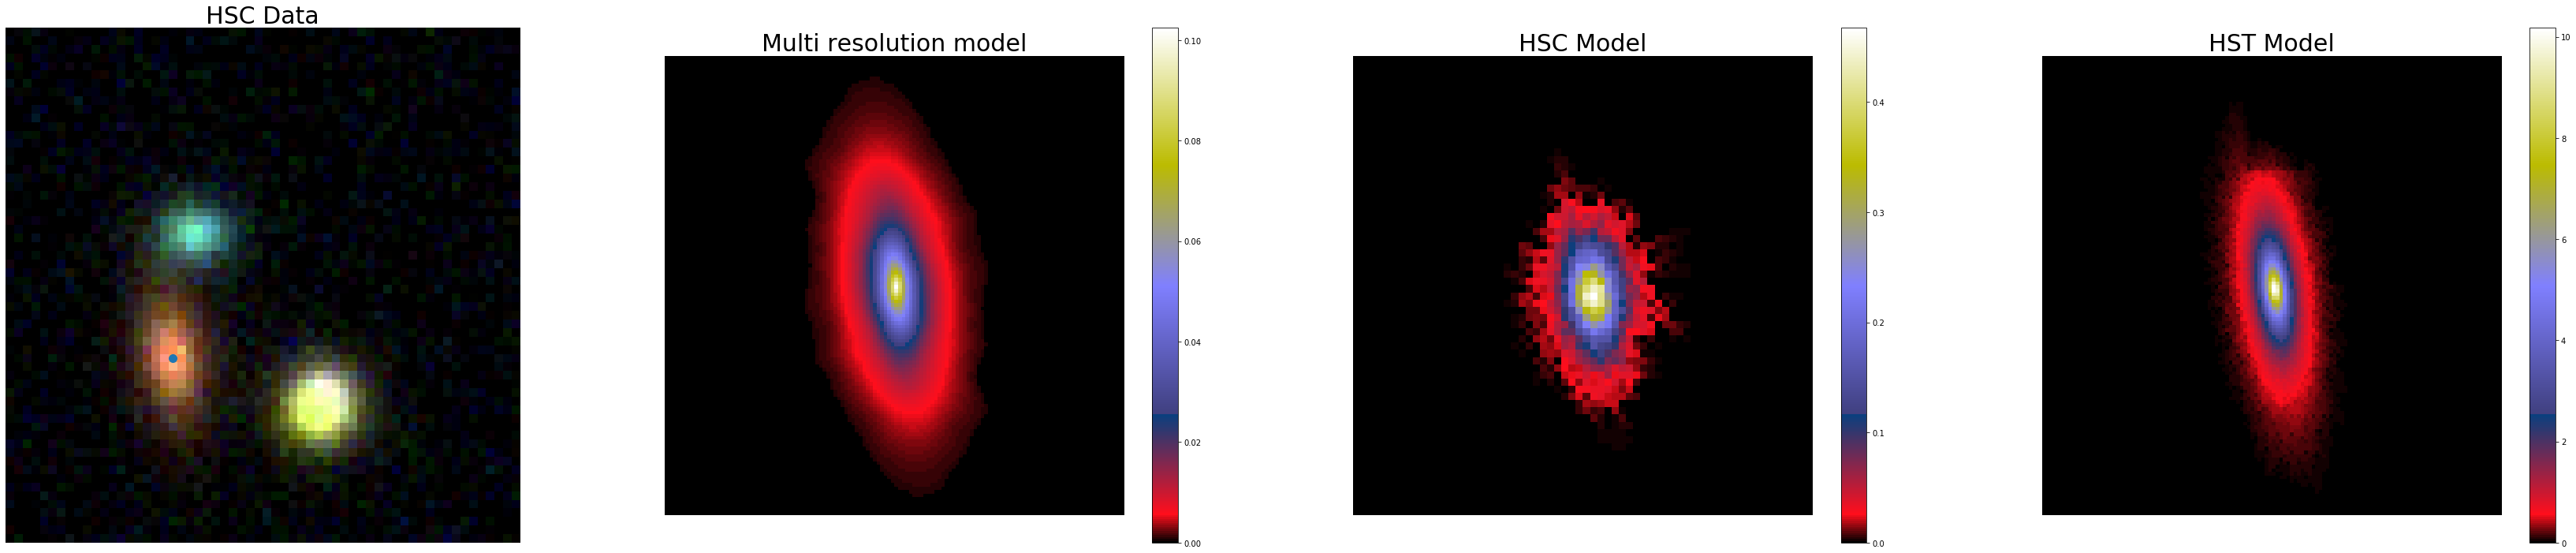

source number  2


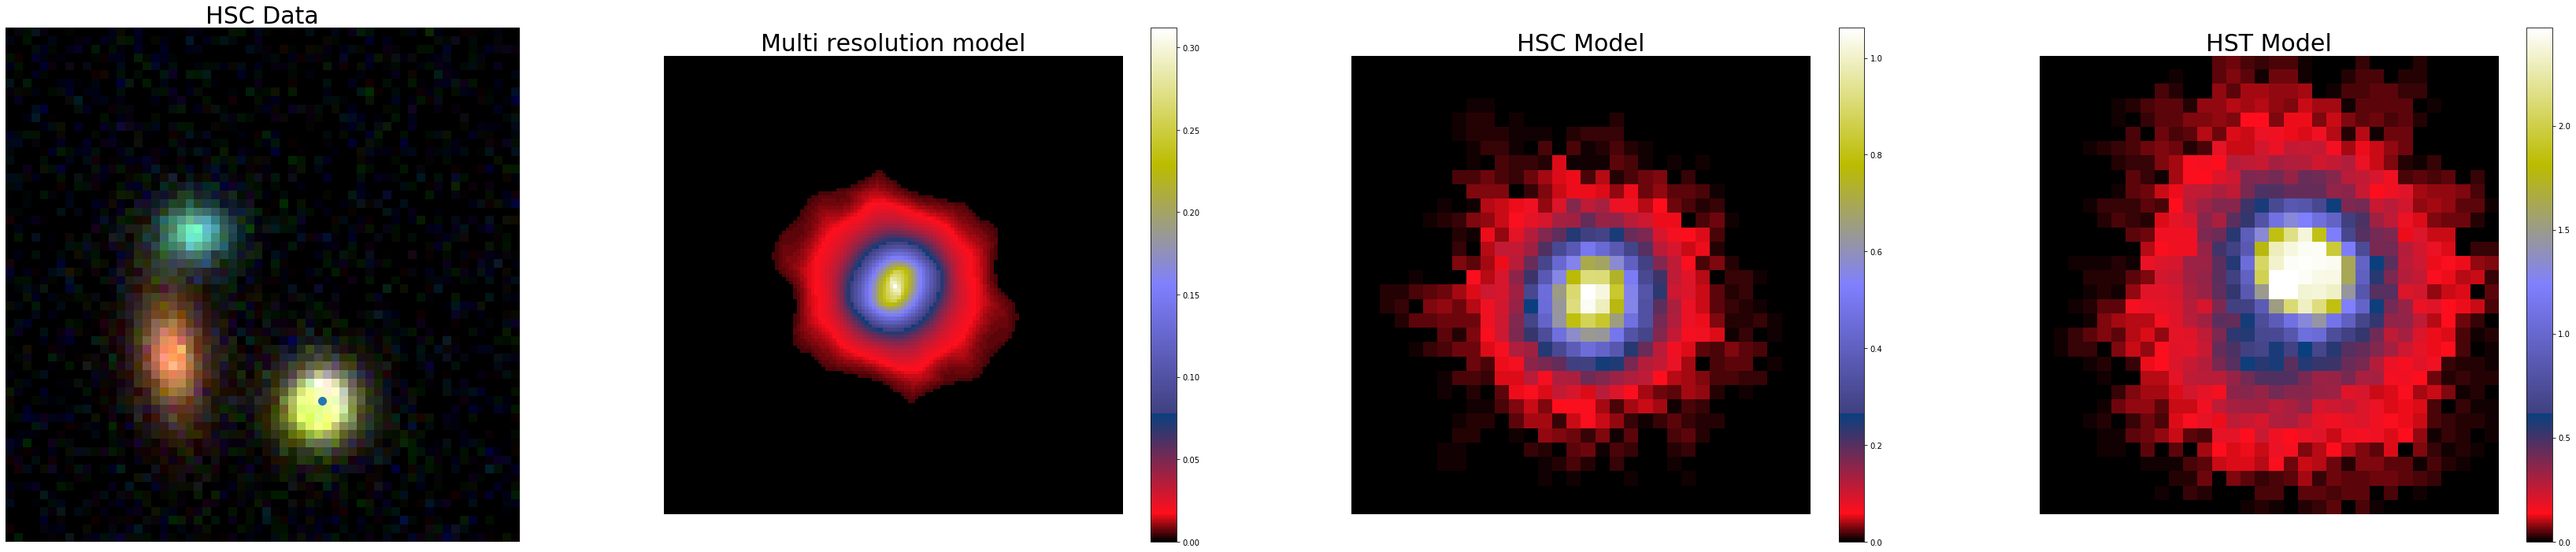

In [24]:
has_truth = False
axes = 2

for k,src in enumerate(blend_multi.sources):
    print('source number ', k)
    # Get the model for a single source
    source_multi = src.get_model()
    source_multilr = blend_multilr[k].get_model()
    source_multihr = blend_multihr[k].get_model()
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = lr_norm)
    
    plt.figure(figsize=(60,12))
    
    plt.subplot(141)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.plot(Xm[k],Ym[k], 'o', markersize = 10)
    plt.title("HSC Data", fontsize = 30)
    plt.subplot(142)
    plt.imshow(source_multi[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("Multi resolution model", fontsize = 30)
    plt.subplot(143)
    plt.imshow(source_multilr[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("HSC Model", fontsize = 30)
    plt.subplot(144)
    plt.imshow(source_multihr[-1])
    plt.axis('off')
    plt.colorbar()
    plt.title("HST Model", fontsize = 30)
    plt.show()

(4, 211, 211) (4, 211, 211)


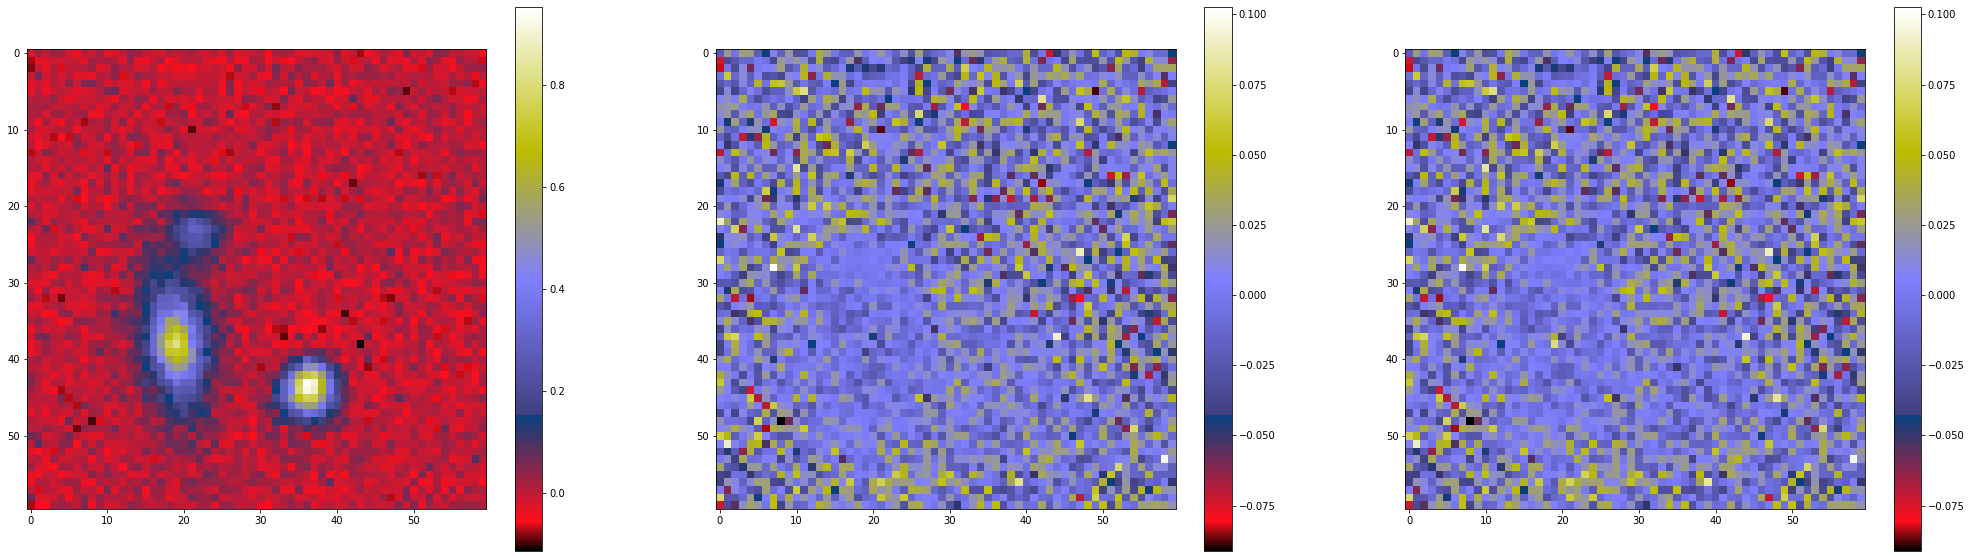

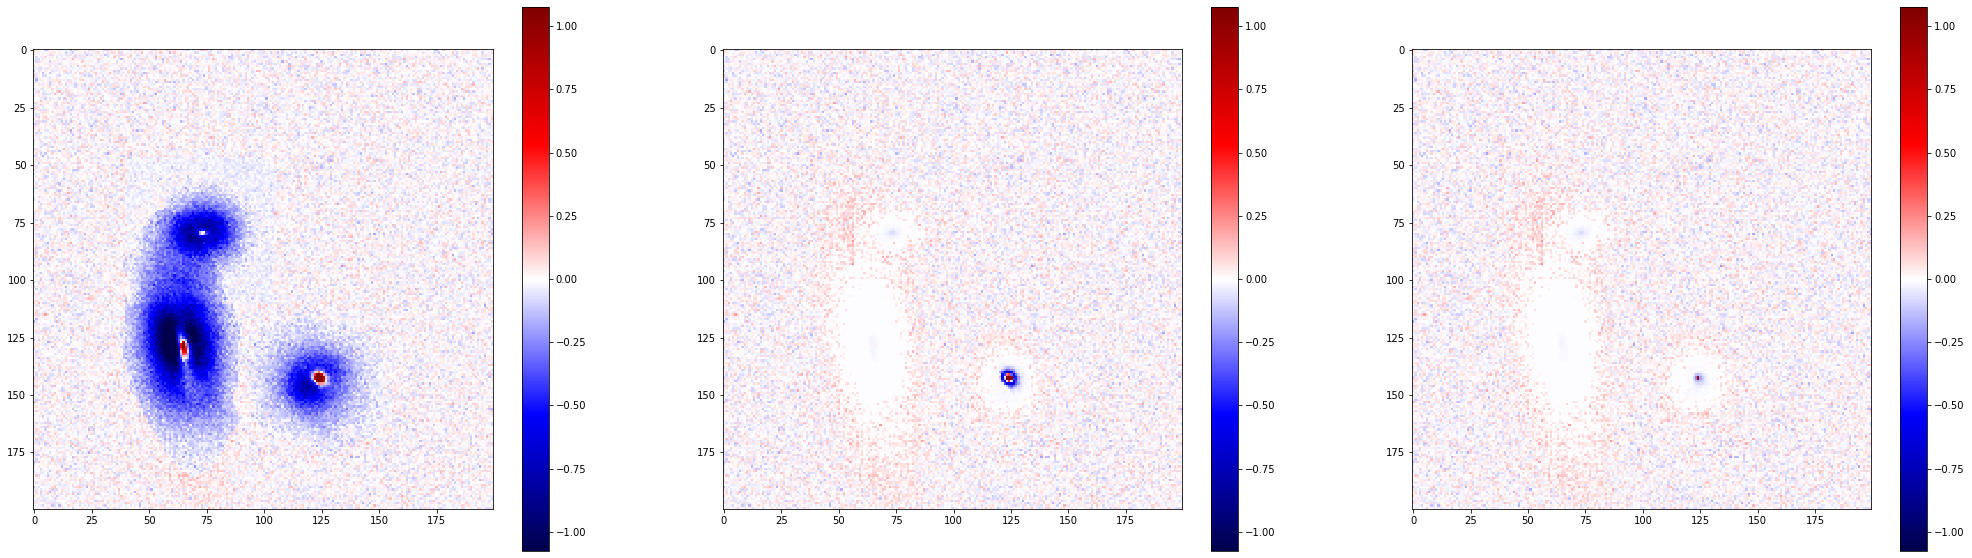

In [25]:
# Results:
model_ = blend_multi.get_model()
mod = []
[mod.append(Starlet(m).filter()) for m in model_multi]
model_multi = np.array(mod)[:,0,:,:]
print(model_multi.shape, model_.shape)
render_hrm = multi_hr.render(model_multi)
render_lrm = multi_lr.render(model_multi)

model_lr = blend_lr.get_model()
render_lr = obs_lr.render(model_lr)

model_hr = blend_hr.get_model()
render_hr = obs_hr.render(model_hr)

model_lrmulti = blend_multilr.get_model()
render_lrmulti = obs_lr.render(model_lrmulti)

model_hrmulti = blend_multihr.get_model()
render_hrmulti = obs_hr.render(model_hrmulti)

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((lr - render_lrm)[2])
plt.colorbar()
plt.subplot(132)
plt.imshow((lr - render_lrmulti)[2])
plt.colorbar()
plt.subplot(133)
plt.imshow((lr - render_lr)[2])
plt.colorbar()
plt.show()

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((hr - render_hrm)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.subplot(132)
plt.imshow((hr - render_hrmulti)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.subplot(133)
plt.imshow((hr - render_hr)[0], cmap="seismic", vmin = -vmax, vmax = vmax)
plt.colorbar()
plt.show()




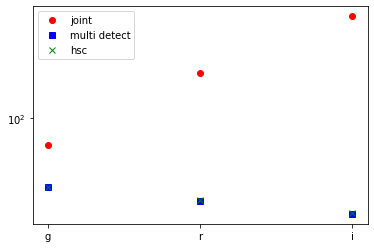

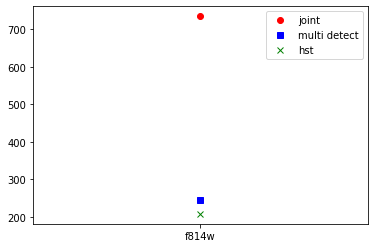

In [26]:
# HSC residuals
chi_joint = (np.sum((lr - render_lrm)**2, axis = (-2,-1))/mad_wavelet(lr)**2)**0.5
chi_multi = (np.sum((lr - render_lrmulti)**2, axis = (-2,-1))/mad_wavelet(lr)**2)**0.5
chi_alone = (np.sum((lr - render_lr)**2, axis = (-2,-1))/mad_wavelet(lr)**2)**0.5

chi_hrm = np.sum((hr - render_hrm)[0]**2/mad_wavelet(hr)**2)**0.5
chi_hrmulti = np.sum((hr - render_hrmulti)**2/mad_wavelet(hr)**2)**0.5
chi_hr = np.sum((hr - render_hr)**2/mad_wavelet(hr)**2)**0.5

plt.plot(['g','r','i'], chi_joint, 'or', label = 'joint')
plt.plot(['g','r','i'], chi_multi, 'sb', label = 'multi detect')
plt.plot(['g','r','i'], chi_alone, 'xg', label = 'hsc')
plt.yscale('symlog')
plt.legend()
plt.show()
# HST residuals
plt.plot(['f814w'], chi_hrm, 'or', label = 'joint')
plt.plot(['f814w'], chi_hrmulti, 'sb', label = 'multi detect')
plt.plot(['f814w'], chi_hr, 'xg', label = 'hst')

plt.legend()
plt.show()
